In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.model_selection import LeaveOneOut

ModuleNotFoundError: No module named 'torch'

In [2]:
chunks_path = "../../data/chunks/mel"
train_val_split = 0.8

In [3]:
import shutil

#Only run this cell once


"""
os.mkdir("mel")
os.mkdir("stft")

for root, dirs, files in os.walk(chunks_path):
    for file in files:
        if file.startswith("mel"):
            shutil.copy(os.path.join(root, file), "./mel")
            
        else:
            shutil.copy(os.path.join(root, file), "./stft")
            
"""

'\nos.mkdir("mel")\nos.mkdir("stft")\n\nfor root, dirs, files in os.walk(chunks_path):\n    for file in files:\n        if file.startswith("mel"):\n            shutil.copy(os.path.join(root, file), "./mel")\n            \n        else:\n            shutil.copy(os.path.join(root, file), "./stft")\n            \n'

In [4]:
class ChunkDataset(Dataset):
    def __init__(self, data_dir, speakers):
        self.data_labels = []
        self.filenames = []
        self.data_dir = data_dir
        for filename in os.listdir(data_dir):
            for speaker in speakers:
                if speaker in filename:
                    self.filenames.append(filename)
                    if filename.split("_")[2] == 'hc':
                        label = 1
                    else:
                        label = 0
                    self.data_labels.append(label)

    def __len__(self):
        return len(self.data_labels)

    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.filenames[idx])
        data = np.genfromtxt(data_path, delimiter=',')
        return data, self.data_labels[idx]

In [5]:
speakers = []
for filename in os.listdir(chunks_path):
    speaker = filename.split("_")[1]
    if speaker not in speakers:
        speakers.append(speaker)
print(speakers)

['ID00', 'ID01', 'ID02', 'ID03', 'ID04', 'ID05', 'ID06', 'ID07', 'ID08', 'ID09', 'ID10', 'ID15', 'ID16', 'ID20', 'ID24', 'ID30', 'ID34', 'ID36']


In [6]:
# Implement leave one out cross validator
leaveOneOut = LeaveOneOut()

# Iterate over the speakers
for train_index, test_index in leaveOneOut.split(speakers):
    full_train_dataset = ChunkDataset(chunks_path, np.take(speakers, train_index))
    test_dataset = ChunkDataset(chunks_path, np.take(speakers, test_index))
    
    train_size = int(train_val_split * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])
    
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    

Text(0, 0.5, 'Frequency bin index')

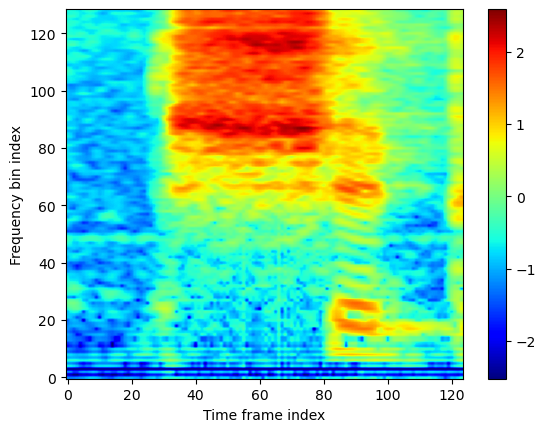

In [7]:
train_features, train_labels = next(iter(train_dataloader))

plt.imshow(train_features[0], cmap='jet', aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time frame index')
plt.ylabel('Frequency bin index')

## CNN (simple case)

In [20]:
train_index = [0, 16]
#train_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
test_index = [17] # test on last speaker

full_train_dataset= ChunkDataset(chunks_path, np.take(speakers, train_index))
test_dataset = ChunkDataset(chunks_path, np.take(speakers, test_index))

train_size = int(train_val_split * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [21]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, BCELoss, LazyLinear

config = {
    "input_shape" : (1,129,124),
    "kernel1" : (2,2),
    "kernel2" : (3,3),
    "hidden1" : 4225,
    "hidden2" : 128,
    "activation" : "relu",
    "batch_size" : 32,
    "lr": 0.000001,
    "momentum" : 1,
    "padding" : "same",
    "pool_size" : (2,2),
    "stride" : 2,
    "epochs" : 5
}



In [22]:

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 64, kernel_size=2, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(64, 64*64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64*64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.5, inplace= True)
        )

        self.linear_layers = Sequential(
            LazyLinear(30),
            ReLU(inplace = True),
            LazyLinear(1)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.flatten(x, 1)
        x = self.linear_layers(x)
        return x

In [23]:
model = Net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

if torch.cuda.is_available():
    print("gpu")
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 4096, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=True)
  )
  (linear_layers): Sequential(
    (0): LazyLinear(in_features=0, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): LazyLinear(in_features=0, out_features=1, bias=True)
  )
)


In [24]:
train_accu = []
train_losses = []

def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        labels = torch.tensor(labels).unsqueeze(1)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        inputs = inputs.to(torch.float32).unsqueeze(1)
        #if torch.cuda.is_available():
        #    inputs = inputs.cuda()
        #    labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.to(torch.float32)
        loss = criterion(outputs.to(torch.float32), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_loss=running_loss/len(train_dataloader)       
    accu=100.*correct/total
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

        



In [25]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()
    running_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            labels = torch.tensor(labels).unsqueeze(1)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
            inputs = inputs.to(torch.float32).unsqueeze(1)
        #if torch.cuda.is_available():
        #    inputs = inputs.cuda()
        #    labels = labels.cuda()

        # forward + backward + optimize
            outputs = model(inputs)
            labels = labels.to(torch.float32)
            loss = criterion(outputs.to(torch.float32), labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    test_loss=running_loss/len(val_dataloader)
    accu=100.*correct/total
        
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [26]:
%%time
nb_epochs = 4
for i in range(nb_epochs):
    model.train(True)
    train(1)
    model.train(False)
    test(1)

/tmp/ipykernel_37/76471847.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1)


KeyboardInterrupt: 

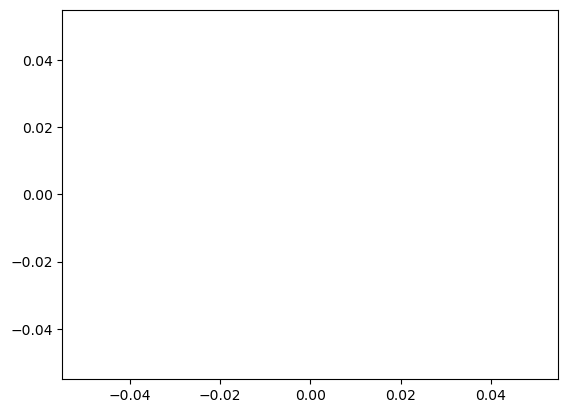

In [27]:
plt.plot(train_losses)
plt.show()

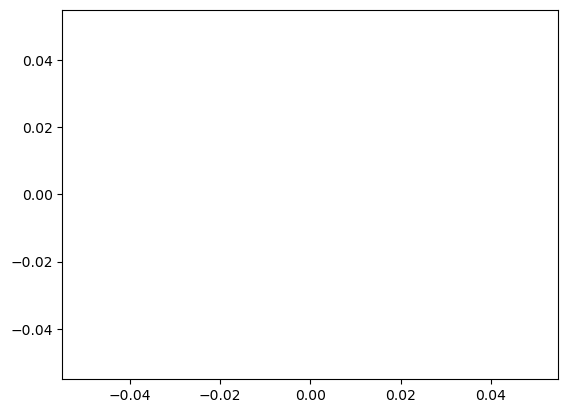

In [28]:
plt.plot(eval_losses)
plt.show()

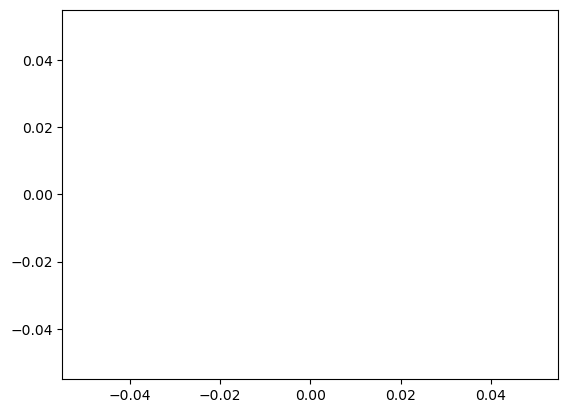

In [29]:
plt.plot(train_accu)
plt.show()

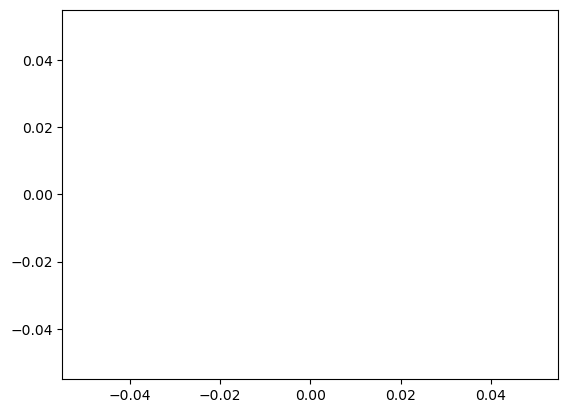

In [30]:
plt.plot(eval_accu)
plt.show()

In [ ]:
PATH = './cnn_net.pth'
torch.save(net.state_dict(), PATH)

In [69]:
for i, (features, label) in enumerate(train_dataloader):
    print(label.shape)
    print(label.unsqueeze(1).shape)
    break

torch.Size([32])
torch.Size([32, 1])


In [19]:
torch.cuda.is_available()

False